<a href="https://colab.research.google.com/github/SLy-Precision/Player-Detection-and-Team-Performance-Prediction/blob/main/04_AEGIS_Simulations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🤖 🔮 AEGIS Simulations 🧪 🎰

## ⚽ Once we did the scouting using advanced metrics (KPI's) now its time to fine-tunning teams with the new player in roster, here we are gonna get the proyections of performance of Club America with these additions 🕹️

In [4]:
# Lets import the libraries we are gonna use 🐍

# Statsbomb api and more
!pip install --quiet statsbombpy
!pip install --quiet mplsoccer
!pip install --quiet highlight_text
!pip install --quiet xgboost

# Libraries for the data manipulation and plot
from statsbombpy import sb
from tqdm import tqdm
import pandas as pd
from mplsoccer import VerticalPitch, Pitch, Sbapi
from highlight_text import ax_text, fig_text
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import seaborn as sns
import numpy as np
from collections import defaultdict
from collections import Counter
from itertools import groupby
from mplsoccer import Pitch
import random

# Machine Learning

from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.utils.class_weight import compute_sample_weight
import matplotlib.pyplot as plt

In [5]:
# Access to drive and files

from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/My Drive/Proyect_Hackathon/'

# Data needed

df_AEGIS_simulation = pd.read_pickle(path + 'df_with_context0.pkl')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
id_america = 1229
team_name_prefix = 'club_america'

### 🤼‍♀ Analysis of Substitutions

In [13]:
array_recommendations = [5738,26311]
array_replaced = [35690,26400]

--- Counting Events for Players to be Replaced (Context: Team ID 1229) ---
Player ID 35690: 3119 events
Player ID 26400: 3547 events

--- Counting Events for Recommended Players (Context: All Teams) ---
Player ID 5738: 2929 events
Player ID 26311: 1455 events

--- Generating Comparison Charts ---
Chart saved: comparison_player_35690_vs_5738.png


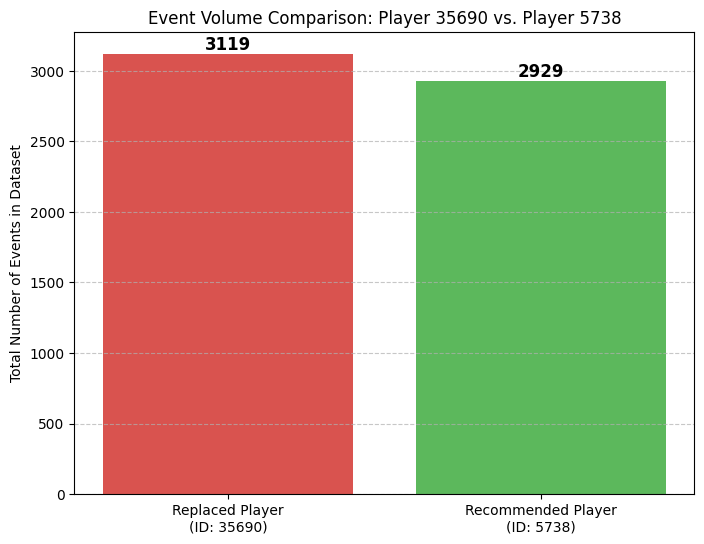

Chart saved: comparison_player_26400_vs_26311.png


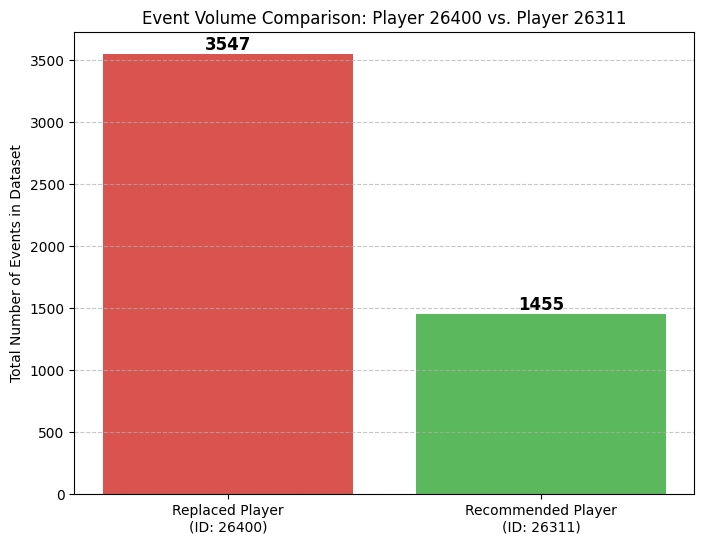

In [15]:
# --- 2. DATA PREPARATION ---
df_AEGIS_simulation['team_id'] = np.where(
    df_AEGIS_simulation['IsHomeTeam'] == 1,
    df_AEGIS_simulation['home_team_id'],
    df_AEGIS_simulation['away_team_id']
)


# --- 3. ANALYSIS: COUNT EVENTS ---
df_america = df_AEGIS_simulation[df_AEGIS_simulation['team_id'] == id_america]
replaced_player_events = {}
recommended_player_events = {}

print(f"--- Counting Events for Players to be Replaced (Context: Team ID {id_america}) ---")
for player_id in array_replaced:
    count = df_america[df_america['playerId'] == player_id].shape[0]
    replaced_player_events[player_id] = count
    print(f"Player ID {player_id}: {count} events")

print("\n--- Counting Events for Recommended Players (Context: All Teams) ---")
for player_id in array_recommendations:
    count = df_AEGIS_simulation[df_AEGIS_simulation['playerId'] == player_id].shape[0]
    recommended_player_events[player_id] = count
    print(f"Player ID {player_id}: {count} events")


# --- 4. VISUALIZATION: GENERATE AND DISPLAY BAR CHARTS ---

print("\n--- Generating Comparison Charts ---")
for replaced_id, recommended_id in zip(array_replaced, array_recommendations):
    replaced_count = replaced_player_events.get(replaced_id, 0)
    recommended_count = recommended_player_events.get(recommended_id, 0)

    players_labels = [f'Replaced Player\n(ID: {replaced_id})', f'Recommended Player\n(ID: {recommended_id})']
    event_counts = [replaced_count, recommended_count]

    plt.figure(figsize=(8, 6))
    bars = plt.bar(players_labels, event_counts, color=['#d9534f', '#5cb85c'])

    plt.ylabel('Total Number of Events in Dataset')
    plt.title(f'Event Volume Comparison: Player {replaced_id} vs. Player {recommended_id}')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom', ha='center', fontsize=12, fontweight='bold')

    filename = f'comparison_player_{replaced_id}_vs_{recommended_id}.png'
    plt.savefig(filename)
    print(f"Chart saved: {filename}")

    plt.show()

    plt.close()

## ⚠️ Simulation Player 1: